In [54]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from algorithms import globals
import os

In [55]:
def plot_function(curr_f):
    x = np.linspace(globals.def_clamps[0], globals.def_clamps[1], 100)
    y = np.linspace(globals.def_clamps[0], globals.def_clamps[1], 100)
    X, Y = np.meshgrid(x, y)
    objecitve_f = curr_f["func"](ndim=2)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = objecitve_f.evaluate([X[i, j], Y[i, j]])

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

    ax.set_title(f"{curr_f['shortname']}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X,Y)')

    plt.show()


In [ ]:
logs = [
    { "name" : "Adam norm lr=0.001 B1=0.8 B2=0.99", "path": "./Adam/adam_logs_norm_lr=0.001_B1=0.8_B2=0.99/adam_records_", "run_path": "./Adam/adam_logs_norm_lr=0.001_B1=0.8_B2=0.99/adam_run_records_"},
    { "name" : "Adam norm lr=0.01 B1=0.8 B2=0.99", "path": "./Adam/adam_logs_norm_lr=0.01_B1=0.8_B2=0.99/adam_records_", "run_path": "./Adam/adam_logs_norm_lr=0.01_B1=0.8_B2=0.99/adam_run_records_"},
    { "name" : "Adam lr=0.01 B1=0.9 B2=0.999", "path": "./Adam/adam_logs_lr=0.01/adam_records_", "run_path": "./Adam/adam_logs_lr=0.01/adam_run_records_"},
    { "name" : "Adam norm lr=0.01 B1=0.9 B2=0.999", "path": "./Adam/adam_logs_norm_lr=0.01/adam_records_", "run_path": "./Adam/adam_logs_norm_lr=0.01/adam_run_records_"},
    { "name" : "Adam norm lr=0.001 B1=0.9 B2=0.999", "path": "./Adam/adam_logs_norm_lr=0.001/adam_records_", "run_path": "./Adam/adam_logs_norm_lr=0.001/adam_run_records_"},
    { "name" : "CMAES", "path": "./CMAES/cmaes_logs/cmaes_records_", "run_path": "./CMAES/cmaes_logs/cmaes_run_records_"},
]

In [57]:
def get_records(path, curr_f):

    if not os.path.exists(path):
        records = None
    else:
        records = []
        with open(path, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                converted_row = {
                    key: (float(value) if key != 'function' else value)
                    for key, value in row.items()
                }
                records.append(converted_row)

    return records


In [ ]:
def get_run_records(path, curr_f):
    if not os.path.exists(path):
        records = None
    else:
        records = []
        with open(path, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                converted_row = {
                    key: (float(value.strip('[]')) if key != 'function' else value)
                    for key, value in row.items()
                }
                records.append(converted_row)

    return records


In [59]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [ ]:
def compare(logs):
    for curr_f in globals.CEC2013:
        plot_function(curr_f)

        run_records_by_method = {}
        records_by_method = {}

        # Load all records
        for method in logs:
            record_path = f"{method['path']}{curr_f['shortname']}.csv"
            run_record_path = f"{method['run_path']}{curr_f['shortname']}.csv"

            records_by_method[method['name']] = get_records(record_path, curr_f)
            run_records_by_method[method['name']] = get_run_records(run_record_path, curr_f)

        fig, axs = plt.subplots(2, 3, figsize=(20, 12))
        axs = axs.flatten()

        plot_idx = 0

        # ECDF plots
        for dim in globals.def_dimensions:
            ax = axs[plot_idx]
            for method_name, run_records in run_records_by_method.items():
                if run_records is None:
                    continue
                errors = [r['error'] for r in run_records if r['dimension'] == dim]
                if not errors:
                    continue
                x, y = ecdf(errors)
                ax.step(x, y, where='post', label=method_name)

            ax.set_xlabel('Error')
            ax.set_ylabel('ECDF')
            ax.set_title(f"{curr_f['shortname']}, ECDF, dim={dim}")
            ax.set_xscale('log')
            ax.legend()
            ax.grid(True)

            plot_idx += 1

        # Mean + Std plots
        for dim in globals.def_dimensions:
            ax = axs[plot_idx]
            for method_name, records in records_by_method.items():
                means = []
                stds = []

                for checkpoint in globals.def_checkpoints:
                    if records:
                        mean_vals = [r['mean'] for r in records if r['dimensions'] == dim and r['checkpoint'] == checkpoint]
                        std_vals = [r['std'] for r in records if r['dimensions'] == dim and r['checkpoint'] == checkpoint]
                        means.append(np.mean(mean_vals) if mean_vals else 0)
                        stds.append(np.mean(std_vals) if std_vals else 0)
                    else:
                        means.append(0)
                        stds.append(0)

                ax.plot(globals.def_checkpoints, means, label=method_name, marker='o')
                ax.fill_between(globals.def_checkpoints,
                                np.array(means) - np.array(stds),
                                np.array(means) + np.array(stds),
                                alpha=0.2)

            ax.set_xlabel('Checkpoint')
            ax.set_ylabel('Error')
            ax.set_title(f"{curr_f['shortname']}, mean and std, dim={dim}")
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.legend()
            ax.grid(True)

            plot_idx += 1

        plt.tight_layout()
        plt.show()


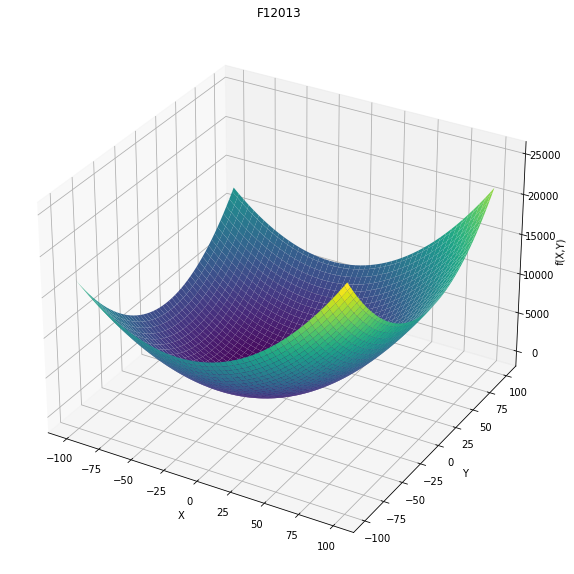

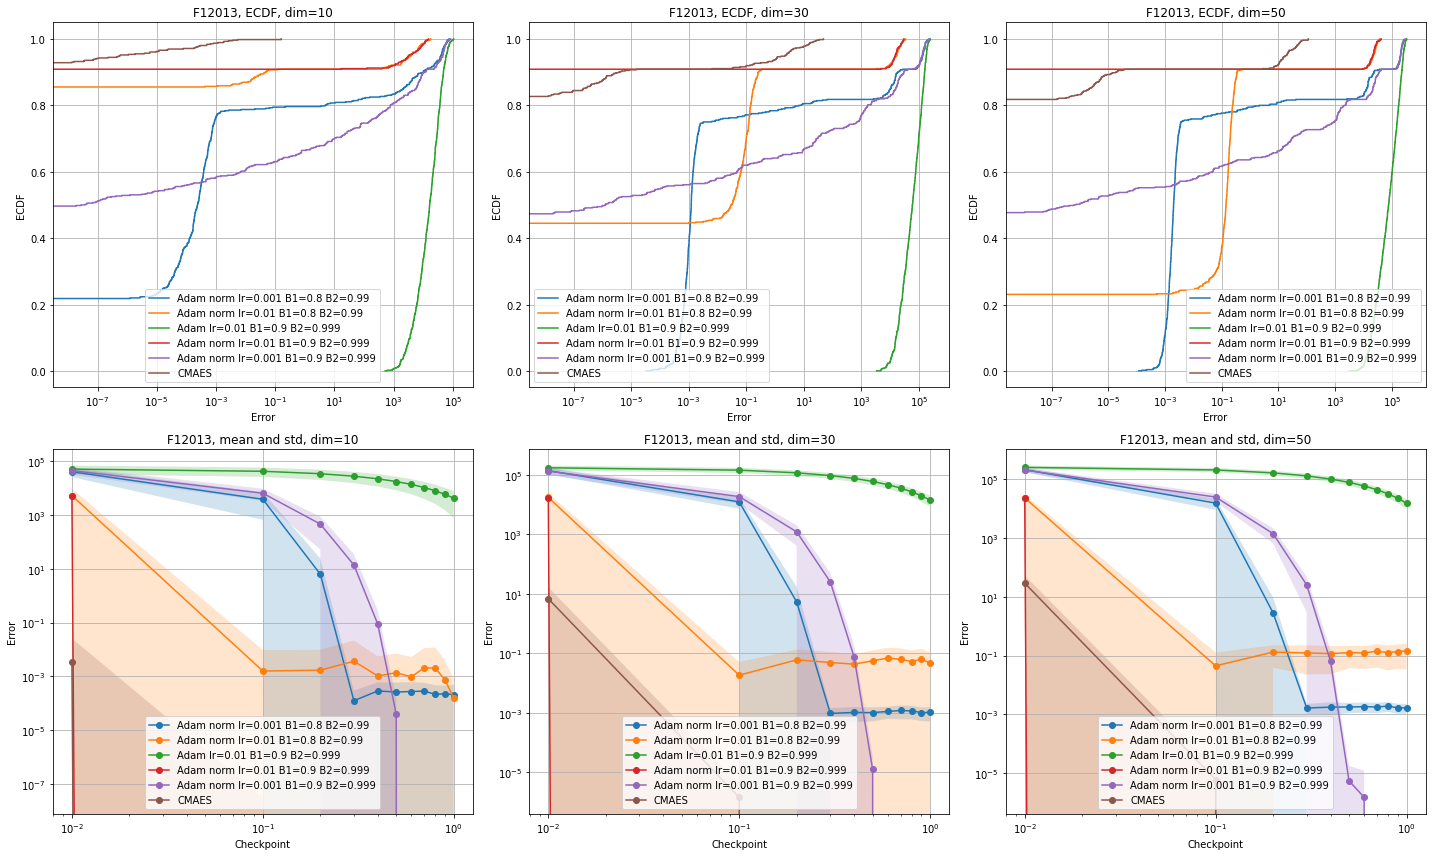

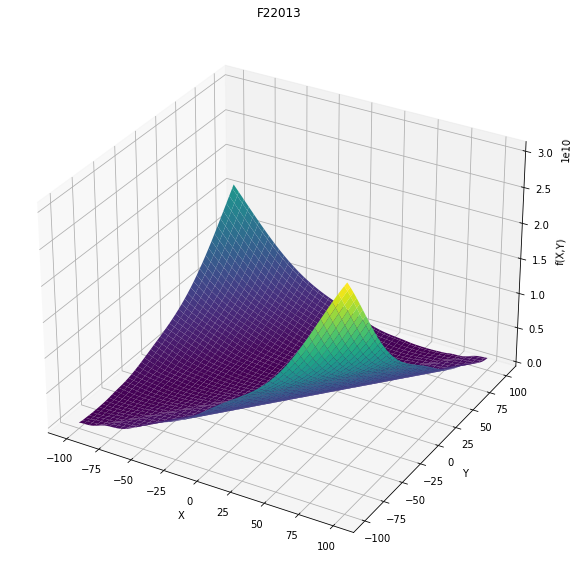

KeyboardInterrupt: 

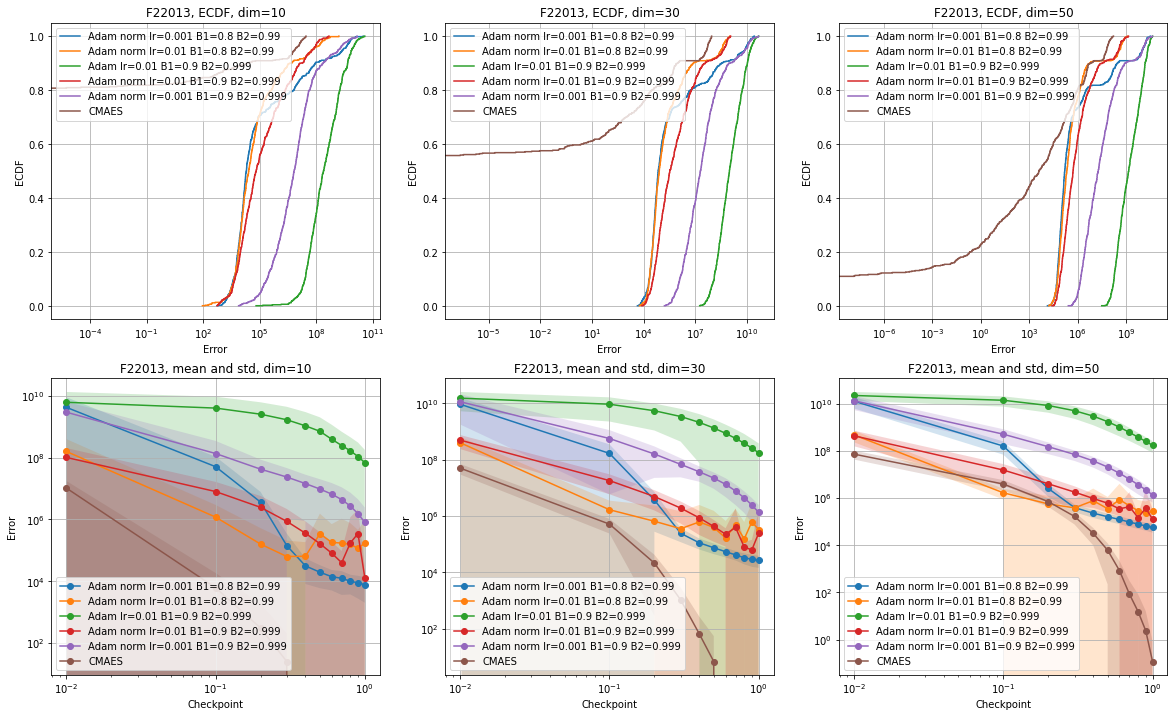

In [ ]:

compare(logs)